In [1]:
import scipy
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from src.IterativeFitting import IterativeFitting as IF
from src.CorrFuncs import covariance_matrix, trend_est

#### Example in GL Paper

In [19]:
x = np.array([2,6,11])
Nx = np.array([337,167,186,212])
M1x = 451
Lx = np.array([np.log(0.80),np.log(1.16),np.log(1.57)])
vx = np.array([0.0542,0.0563,0.0563])
A0 = M1x*Nx[1:]/(Nx.sum())

In [20]:
it_fit_ex = IF(Lx,A0,Nx,M1x)

In [21]:
A, B, a0, b0 = it_fit_ex.convexProgram()

In [22]:
A

array([ 70.33038633,  95.48567119, 124.67758726])

In [23]:
A_GL = it_fit_ex.GL()

In [24]:
A_GL

(array([ 70.20458464,  95.46963796, 124.85560373]),
 160.47017367350816,
 array([96.79541536, 90.53036204, 87.14439627]),
 176.52982632649184,
 2)

In [25]:
A_GLN = it_fit_ex.GL_linesearch()

In [26]:
A_GLN

(array([ 70.33753879,  95.44494158, 124.66704769]),
 160.55047193677308,
 array([96.66246121, 90.55505842, 87.33295231]),
 176.44952806322692,
 2)

In [27]:
trend_est(A,B,a0,b0,vx,x,Lx,unadj=False)

(0.045430215893878516, 0.0004268215544488761)

#### Example from alochol data in $\verb+dosresmeta+$

In [14]:
x = np.array([9.06,27.,45.,64.8])
Nx = np.array([414,261,228,44,34])
A0 = np.array([61,69,22,19])
M1x = np.sum(A0) + 126
Lx = np.array([-0.2231435,-0.0001,0.5306283,0.8754687])
vx = np.array([0.2233380,0.2337519,0.3765137,0.4440046])

In [15]:
alcohol_data = IF(Lx,A0,Nx,M1x)

In [16]:
result_alc = alcohol_data.convexProgram()

In [17]:
result_alc

(array([67.12135054, 68.86105977, 18.64972113, 17.32195872]),
 array([193.87864946, 159.13894023,  25.35027887,  16.67804128]),
 125.04590983884529,
 288.9540901611547)

#### RR example where everything works

In [2]:
x = np.array([1.8286, 9.1992, 22.8571, 35.6667, 58.4257])
A = np.array([38., 43., 32., 16., 27.])
a0 = 28
M1 = np.sum(A) + a0
B = np.array([22185.73, 43030.54, 53088.96, 45348.09, 19790.79, 19919.85])
L = np.array([-0.41673, -0.39555, -0.48842, -0.27903, 0.20232])
v = np.array([0.2510976, 0.2456013, 0.2633819, 0.3208115, 0.2861643])
v *= v

In [3]:
RR_ex = IF(L,A,B,M1)

In [4]:
A_GLRR, a0_GLRR, B_GLRR, b0_GLRR, iter_GLRR = RR_ex.GL(OR=False)

In [5]:
A_GLRR

array([33.88106778, 42.96697564, 33.41520852, 17.88177706, 29.21975009])

In [6]:
A_cvxRR, B_cvxRR, a0_cvxRR, b0_cvxRR = RR_ex.convexProgram(OR=False)

In [7]:
A_cvxRR

array([34.00610242, 42.85317043, 33.35834454, 17.94921829, 29.23587682])

In [8]:
B_cvxRR

array([43030.54, 53088.96, 45348.09, 19790.79, 19919.85])

Our convex formulation matches EXACTLY with what is in $\verb+dosresmeta+$.

#### OR Example that doesn't work on $\verb+dosresmeta+$ but works for our method

In [3]:
x = np.array([2,6,11])
Nx = np.array([337,167,186,212])
M1x = 451
Lx = np.array([np.log(0.80),np.log(1.16),np.log(1.57)])
vx = np.array([0.0542,0.0563,0.0563])
A0 = Nx[1:] - 1.

In [4]:
alcohol_data_2 = IF(Lx,A0,Nx,M1x)
alcohol_data_2.GL()

/Users/Johnson/Documents/Sasha_Research/CvxFitting/src/IterativeFitting.py:172: RuntimeWarning: invalid value encountered in log
  e = L + np.log(a0) + np.log(B) - np.log(A) - np.log(b0)


ValueError: array must not contain infs or NaNs

In [6]:
alcohol_data_2.convexProgram()

(array([101.12206468, 128.33876093]),
 array([65.87793532, 57.66123907]),
 221.5391743924633,
 115.46082560753669)

As we can see here, our method is working when their method doesn't work. Notice we don't have to give any initial guess. As such, we do not need to know any crude observed totals for the cases initially.

#### Grid values where it works vs when it doesn't work

In [17]:
x = np.array([2,6])
Nx = np.array([337,167,186,212])
M1x = 451
Lx = np.array([np.log(0.80),np.log(1.16),np.log(1.57)])
A0 = np.array([74,90,122])

In [46]:
x,y = np.meshgrid(np.arange(1,Nx[1],1),np.arange(1,Nx[2],1))
A0_vals = np.vstack([x.flatten(),y.flatten()]).T*1.
z = np.array([122 for _ in range(A0_vals.shape[0])])
z = np.array([z]).T
A0_vals = np.hstack((A0_vals,z))
failed_A0=[]
succeeded_A0 = []
for i in range(len(A0_vals)):
    alcohol_data_2 = IF(Lx,A0_vals[i],Nx,M1x)
    try:
        alcohol_data_2.GL()
        succeeded_A0+=[A0_vals[i]]
    except:
        failed_A0+=[A0_vals[i]]

/Users/Johnson/Documents/Sasha_Research/CvxFitting/src/IterativeFitting.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  c0 = 1/a0 + 1/b0
/Users/Johnson/Documents/Sasha_Research/CvxFitting/src/IterativeFitting.py:172: RuntimeWarning: divide by zero encountered in log
  e = L + np.log(a0) + np.log(B) - np.log(A) - np.log(b0)
/Users/Johnson/Documents/Sasha_Research/CvxFitting/src/IterativeFitting.py:172: RuntimeWarning: invalid value encountered in log
  e = L + np.log(a0) + np.log(B) - np.log(A) - np.log(b0)


In [48]:
A0_vals

array([[  1.,   1., 122.],
       [  2.,   1., 122.],
       [  3.,   1., 122.],
       ...,
       [164., 185., 122.],
       [165., 185., 122.],
       [166., 185., 122.]])

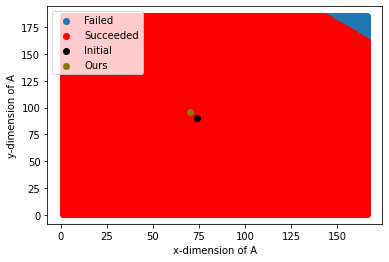

In [50]:
failed_A0 = np.array(failed_A0)
succeeded_A0=np.array(succeeded_A0)
plt.scatter(failed_A0[:,0],failed_A0[:,1],label="Failed")
plt.scatter(succeeded_A0[:,0],succeeded_A0[:,1],c='red',label="Succeeded")
plt.scatter(A0[0],A0[1],c='black',label="Initial")
plt.scatter(alcohol_data_2.convexProgram()[0][0],alcohol_data_2.convexProgram()[0][1],c='olive',label="Ours")
plt.xlabel("x-dimension of A")
plt.ylabel("y-dimension of A")
plt.legend(loc="upper left")